## Import Libs

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
from numpy import load
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow.math import confusion_matrix
from datetime import datetime

## Set Project basepath

In [2]:
basepath = r"C:\Users\pascs\Desktop\Project Computer Vision"

## Set image Size

In [3]:
img_size = "150"

## Load the Datasets

In [4]:
if img_size == "150":
    x_test = load(os.path.join(basepath, "data_test.npz"))['arr_0']
    x_train = load(os.path.join(basepath, "data_train.npz"))['arr_0']
    y_test = load(os.path.join(basepath, "labels_test.npz"))['arr_0']
    y_train = load(os.path.join(basepath, "labels_train.npz"))['arr_0']
elif img_size == "50":
    x_test = load(os.path.join(basepath, "sub_data_test.npz"))['arr_0']
    x_train = load(os.path.join(basepath, "sub_data_train.npz"))['arr_0']
    y_test = load(os.path.join(basepath, "sub_labels_test.npz"))['arr_0']
    y_train = load(os.path.join(basepath, "sub_labels_train.npz"))['arr_0']
    
elif img_size == "96":
    x_test = load(os.path.join(basepath, "sub_data_test_96.npz"))['arr_0']
    x_train = load(os.path.join(basepath, "sub_data_train_96.npz"))['arr_0']
    y_test = load(os.path.join(basepath, "sub_labels_test.npz"))['arr_0']
    y_train = load(os.path.join(basepath, "sub_labels_train.npz"))['arr_0']
    
elif img_size == "160":
    x_test = load(os.path.join(basepath, "data_test_160.npz"))['arr_0']
    x_train = load(os.path.join(basepath, "data_train_160.npz"))['arr_0']
    y_test = load(os.path.join(basepath, "labels_test.npz"))['arr_0']
    y_train = load(os.path.join(basepath, "labels_train.npz"))['arr_0']
    
    
print('Shape x_test: ', x_test.shape)
print('Shape x_train: ', x_train.shape)
print('Shape y_test: ', y_test.shape)
print('Shape y_train: ', y_train.shape)

Shape x_test:  (1000, 150, 150, 3)
Shape x_train:  (4000, 150, 150, 3)
Shape y_test:  (1000,)
Shape y_train:  (4000,)


## On the fly Image Data Generator

In [5]:
# perform one-hot encoding on the labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train))

y_test = to_categorical(le.fit_transform(y_test))

# Split of data into train and test


aug = ImageDataGenerator(
    zoom_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

## Modeling

In [6]:
INIT_LR = 1e-4 # learning rate
EPOCHS = 15 
BS = 32 # Batchsize
#Modeltype = "PretrainedMobileNetV2_Flatten_4Dense_Dropout_Dense"
Modeltype = "PretrainedMobileNetV2_Flatten_3Dense_l2"

In [7]:
# We first load the MobilNetV2 by removing the last layers since
# we want to do transfer learning.

if Modeltype =="PretrainedMobileNetV2_Flatten_3Dense_l2":
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(int(img_size), int(img_size), 3)))
    # The following are the layers we will train
    headModel = baseModel.output
    #headModel = AveragePooling2D(pool_size=(2,2))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dense(64, activation="relu", kernel_regularizer='l2')(headModel)
    headModel = Dense(8, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    # We don't want to train any layer in the MobileNetV2 network
    
elif Modeltype == "PretrainedMobileNetV2_Flatten_4Dense_Dropout_Dense":
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(int(img_size), int(img_size), 3)))
    # The following are the layers we will train
    headModel = baseModel.output
    #headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(8, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 19, 19, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
          

                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 10, 10, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malizatio

 block_10_project (Conv2D)      (None, 10, 10, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_

 block_14_depthwise_BN (BatchNo  (None, 5, 5, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_

In [8]:
import tensorflow as tf
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

#device_name = tf.test.gpu_device_name()
#if device_name == '/device:GPU:0':
  #print("GPU found")
H = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    epochs=EPOCHS)

C:\Users\pascs\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
125/125 [==============================] - 52s 396ms/step - loss: 1.9343 - accuracy: 0.6325 - val_loss: 1.9057 - val_accuracy: 0.6460
Epoch 2/15
125/125 [==============================] - 51s 409ms/step - loss: 1.6052 - accuracy: 0.7172 - val_loss: 1.8467 - val_accuracy: 0.6270
Epoch 3/15
125/125 [==============================] - 52s 415ms/step - loss: 1.4382 - accuracy: 0.7448 - val_loss: 1.6056 - val_accuracy: 0.6790
Epoch 4/15
125/125 [==============================] - 55s 443ms/step - loss: 1.3109 - accuracy: 0.7623 - val_loss: 1.4827 - val_accuracy: 0.7100
Epoch 5/15
125/125 [==============================] - 55s 437ms/step - loss: 1.1843 - accuracy: 0.7918 - val_loss: 1.3702 - val_accuracy: 0.7170
Epoch 6/15
125/125 [==============================] - 46s 365ms/step - loss: 1.1162 - accuracy: 0.7968 - val_loss: 1.3113 - val_accuracy: 0.7140
Epoch 7/15
125/125 [==============================] - 48s 383ms/step - loss: 1.0287 - accuracy: 0.7983 - val_loss: 1.3000 - val_ac

In [9]:

date_time_now = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
name_string = str(img_size)+"_epochs_"+str(EPOCHS)+"_"+"LR_"+str(INIT_LR)+"_BS_"+str(BS)+"_time_"+date_time_now+"_"+Modeltype

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 19, 19, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 19, 19, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 19, 19, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 19, 19, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

## Confusion Matrix

In [10]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BS)
print(predIdxs.shape)
print(y_test.shape) 

y_classes = np.argmax(predIdxs, axis=1)
y_test2 =  np.argmax(y_test, axis=1)
model.save('model_imgsize_'+name_string+".h5", save_format="h5")
np.save('history_imgsize_'+name_string+'.npy',H.history)
confusion_matrix(
    y_test2,
    y_classes,
)

[INFO] evaluating network...
32/32 [==============================] - 8s 216ms/step
(1000, 8)
(1000, 8)


<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[109,   9,   8,   3,  12,   0,   0,   0],
       [  2,  99,   8,   4,  14,   2,   0,   0],
       [ 25,  22,  32,  16,  23,   0,   0,   0],
       [ 11,   0,   1,  98,   1,   1,   0,   0],
       [  8,  46,   0,   0,  55,  13,   0,   4],
       [ 28,  15,  16,  12,   8,  50,   0,   0],
       [  0,   0,   0,   0,   0,   0, 127,   3],
       [  0,   1,   0,   0,   1,   0,   1, 112]])>

## Plot Loss Function

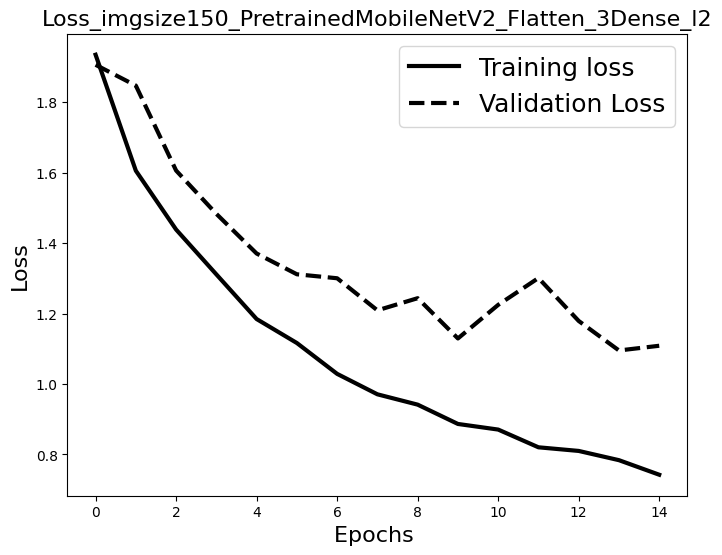

In [11]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.title('Loss_imgsize'+img_size+"_"+Modeltype,fontsize=16)
plt.plot(H.history['loss'],'black',linewidth=3.0)
plt.plot(H.history['val_loss'],'black',ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.savefig('Loss_imgsize'+img_size+"_"+Modeltype)
plt.show()

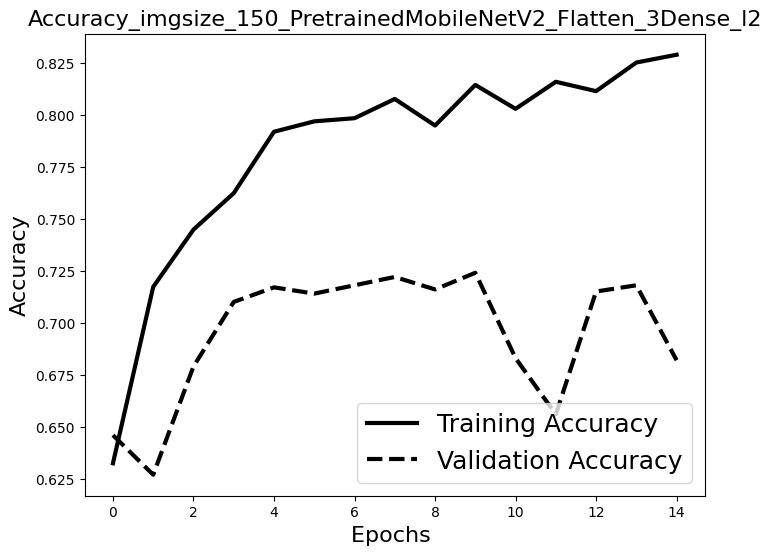

In [12]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.title('Accuracy_imgsize_'+img_size+"_"+Modeltype,fontsize=16)
plt.plot(H.history['accuracy'],'black',linewidth=3.0)
plt.plot(H.history['val_accuracy'],'black',ls = '--',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18,
           loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.savefig('Accuracy_imgsize_'+img_size+"_"+Modeltype)
plt.show()

In [13]:
acc = H.history['val_accuracy']
acc

[0.6460000276565552,
 0.6269999742507935,
 0.6790000200271606,
 0.7099999785423279,
 0.7170000076293945,
 0.7139999866485596,
 0.7179999947547913,
 0.722000002861023,
 0.7160000205039978,
 0.7239999771118164,
 0.6830000281333923,
 0.656000018119812,
 0.7149999737739563,
 0.7179999947547913,
 0.6819999814033508]

In [27]:
model_loaded = tf.keras.models.load_model("model_imgsize_50_epochs_15_LR_0.0001_BS_32_time_02_09_2023_13_34_03_PretrainedMobileNetV2_Flatten_4Dense_Dropout_Dense.h5")
model_loaded

NameError: name 'tf' is not defined

## Load Histories

In [39]:
History_epochs15 = np.load("history_imgsize_50_epochs_15_02_09_2023_09_35_22.npy", allow_pickle = True).item()
History_epochs15_ = np.load("history_imgsize_50_epochs_15_LR_0.0001_BS_32_time_02_09_2023_13_34_41_PretrainedMobileNetV2_Flatten_4Dense_Dropout_Dense.npy", allow_pickle = True).item()
History_epochs15

{'loss': [1.421160101890564,
  1.2757225036621094,
  1.214409351348877,
  1.1810163259506226,
  1.160791039466858,
  1.1430933475494385,
  1.130969524383545,
  1.1249783039093018,
  1.1111942529678345,
  1.1053622961044312,
  1.0984573364257812,
  1.0892329216003418,
  1.0855095386505127,
  1.0796113014221191,
  1.0744391679763794],
 'accuracy': [0.44563889503479004,
  0.49408334493637085,
  0.5201388597488403,
  0.5318611264228821,
  0.539027750492096,
  0.5498611330986023,
  0.5560555458068848,
  0.5593888759613037,
  0.5616388916969299,
  0.5642222166061401,
  0.5698055624961853,
  0.570888876914978,
  0.5750277638435364,
  0.5786389112472534,
  0.5765833258628845],
 'val_loss': [1.2528012990951538],
 'val_accuracy': [0.488444447517395]}

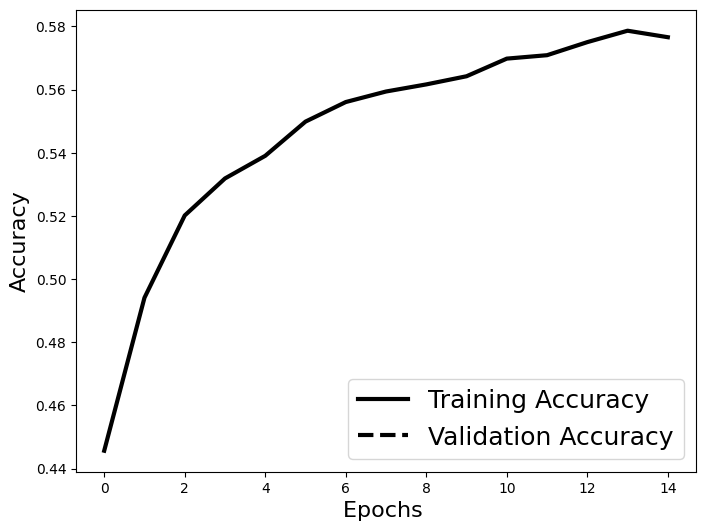

In [40]:
# Accuracy Curves
#plt.title('Accuracy Curves',fontsize=16)
plt.figure(figsize=[8,6])
plt.plot(History_epochs15['accuracy'],'black',linewidth=3.0)
plt.plot(History_epochs15['val_accuracy'],'black',ls = '--',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18,
           loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.show()

In [35]:
History_epochs15['accuracy']

[0.45144444704055786,
 0.5009444355964661,
 0.5224444270133972,
 0.5348333120346069,
 0.5470555424690247,
 0.5490555763244629,
 0.5536388754844666,
 0.5605000257492065,
 0.5649444460868835,
 0.5681388974189758,
 0.5711389183998108,
 0.5715555548667908,
 0.5711944699287415,
 0.5716944336891174,
 0.5788055658340454]